In [1]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
from os.path import join
from rl_analysis.plotting import save_factory, setup_plotting_env, clean_ticks, subplots

In [2]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

setup_plotting_env()

In [4]:
saver = save_factory(join(config['figures']['store_dir'], 'fig-01'), tight_layout=False)

In [6]:
# select specific session (via uuid)
df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "=", "2891f649-4fbd-4119-a807-b8ef507edfab"), ("area", "=", "dls")],
)

df = df.sort_values(by='timestamp')
assert df.shape == (53892, 86), "Not right shape"

In [7]:
n_frames = 361
start = 3520

time = np.arange(n_frames) / 30

vel_angle = (
    df["velocity_angle"]
    .interpolate(limit_direction="both")
    .iloc[start:start + n_frames]
    .to_numpy()
    * 30
)

vel = (
    df["velocity_2d_mm"]
    .interpolate(limit_direction="both")
    .iloc[start:start + n_frames]
    .to_numpy()
    * 30
)

acc = (
    df["acceleration_2d_mm"]
    .interpolate(limit_direction="both")
    .iloc[start:start + n_frames]
    .to_numpy()
    * 30
)

syllables = df["predicted_syllable (offline)"].iloc[start:start + n_frames].to_numpy()

vel_height = (
    df["height_ave_mm"]
    .interpolate(limit_direction="both")
    .diff(2)
    .iloc[start:start + n_frames]
    .to_numpy()
    / 2
    * 30
)

da = df["signal_dff"].iloc[start:start + n_frames].to_numpy()
ref = df["reference_dff"].iloc[start:start + n_frames].to_numpy()

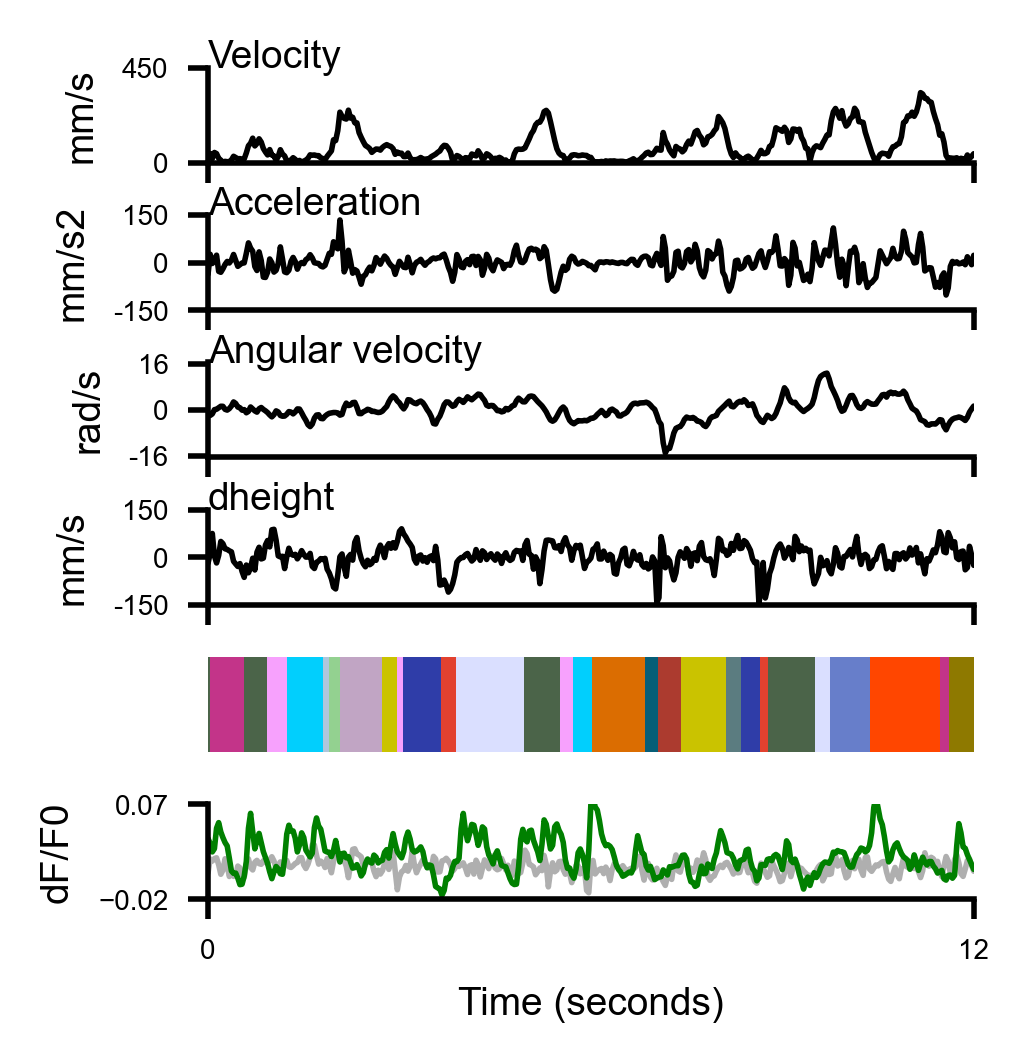

In [9]:
fig, ax = subplots(6, 1, 2.47, 2.7)
fig.dpi = 200

ax[0].plot(time, vel, color='k')
ax[0].set_xlim(time[0], time[-1])
ax[0].set_xticks([time[0], time[-1]])
ax[0].set_xticklabels([])
ax[0].set_ylim(0, 15 * 30)
ax[0].set_ylabel('mm/s')
ax[0].text(0, 1, "Velocity", transform=ax[0].transAxes)
clean_ticks(ax[0], axis="y", precision=1, dtype=int, zero_symmetry=False)

ax[1].plot(time, acc, color='k')
ax[1].set_xlim(time[0], time[-1])
ax[1].set_xticks([time[0], time[-1]])
ax[1].set_xticklabels([])
ax[1].set_ylim(-5 * 30, 5 * 30)
ax[1].set_ylabel('mm/s2')
ax[1].text(0, 1, "Acceleration", transform=ax[1].transAxes)
clean_ticks(ax[1], axis="y", precision=1, dtype=int)


ax[2].plot(time, vel_angle, color='k')
ax[2].set_xlim(time[0], time[-1])
ax[2].set_xticks([time[0], time[-1]])
ax[2].set_xticklabels([])
ax[2].set_ylim(-0.55 * 30, 0.55 * 30)
ax[2].set_ylabel('rad/s')
ax[2].text(0, 1, "Angular velocity", transform=ax[2].transAxes)
clean_ticks(ax[2], axis="y", precision=1, dtype=int)


ax[3].plot(time, vel_height, color='k')
ax[3].set_xlim(time[0], time[-1])
ax[3].set_xticks([time[0], time[-1]])
ax[3].set_xticklabels([])
ax[3].set_ylim(-5 * 30, 5 * 30)
ax[3].set_ylabel('mm/s')
ax[3].text(0, 1, "dheight", transform=ax[3].transAxes)
clean_ticks(ax[3], axis="y", precision=1, dtype=int)


ax[4].imshow(syllables[None, :], aspect='auto', interpolation='none', cmap=cc.cm.glasbey, vmin=0)
ax[4].set_xticks([])
ax[4].set_yticks([])


ax[5].plot(time, ref, color='#afafaf')
ax[5].plot(time, da, color='g')
ax[5].set_ylim(-0.02, 0.07)
ax[5].set_yticks([-0.02, 0.07])
ax[5].set_xlim(time[0], time[-1])
ax[5].set_xticks([time[0], time[-1]])
ax[5].set_ylabel('dF/F0')
ax[5].set_xlabel('Time (seconds)')

sns.despine()
sns.despine(ax=ax[4], bottom=True, left=True)

plt.subplots_adjust(hspace=0.55)
saver(fig, 'scalars-syllables-and-dlight');